In [1]:
import networkx as nx
import numpy as np
import pickle as p
from os import path
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import pyplot as plt
%matplotlib inline
import torch

data_loc = './BlogCatalog3/BlogCatalog-dataset/data/'

## Load Data

In [2]:
def load_data():
    iid = {}
    idx = 0
    edgelist = []

    # Read edges pairs
    with open(data_loc+'edges.csv', 'r') as f:
        for line in f.readlines():
            i, j = line.strip().split(',')  # csv
            if i not in iid:
                iid[i] = idx; idx += 1
            if j not in iid:
                iid[j] = idx; idx += 1
            edgelist.append((iid[i], iid[j]))

    # Create an nx undirected network
    bc = nx.Graph(edgelist)

    print("Number of nodes: ", len(bc))
    print("Number of edges: ", bc.size())

    # Read labels
    labels = np.zeros((len(bc)), dtype=int)
    # Read (node_id, label) file
    with open(data_loc+'group-edges.csv', 'r') as f:
        for line in f.readlines():
            node, group = line.strip().split(',') 
            labels[iid[node]] = int(group)-1  

    bc_dataset = {'graph': bc, 'labels': labels}
    return bc_dataset

bc_dataset = load_data()

Number of nodes:  10312
Number of edges:  333983


In [3]:
print(np.min(bc_dataset['labels']))
print(np.max(bc_dataset['labels']))
unique, counts = np.unique(bc_dataset['labels'], return_counts=True)
print(np.asarray((unique, counts)).T)

0
38
[[   0   60]
 [   1  488]
 [   2  365]
 [   3  119]
 [   4  625]
 [   5  563]
 [   6  393]
 [   7 1076]
 [   8  247]
 [   9  300]
 [  10  325]
 [  11   25]
 [  12   35]
 [  13  239]
 [  14   53]
 [  15  295]
 [  16  351]
 [  17  236]
 [  18  715]
 [  19  247]
 [  20  228]
 [  21  233]
 [  22  279]
 [  23  846]
 [  24  170]
 [  25  242]
 [  26   88]
 [  27   85]
 [  28  155]
 [  29  360]
 [  30   62]
 [  31  371]
 [  32   91]
 [  33   62]
 [  34   58]
 [  35  137]
 [  36   53]
 [  37   27]
 [  38    8]]


In [4]:
import random

def gen_random_walk_tensor(graph, node, length, num_walks):
    walk = torch.zeros((num_walks, length), dtype=int)
    walk[:, 0] = node
    j = 0
    while j < num_walks:
        current_node = node
        step = 1
        while step < length:
            neighbors = list(graph.neighbors(current_node))
            current_node = random.choice(neighbors)
            walk[j, step] = current_node
            step += 1
        j+=1
    return walk

# Assert all edges exist
rws = gen_random_walk_tensor(bc_dataset['graph'], 0, 5, 5)
for walk in range(5):
    rw = rws[walk]
    for step in range(4):
        edge = bc_dataset['graph'].get_edge_data(rw[step].item(), rw[step+1].item()) 
        assert(edge is not None)

In [5]:
rw = gen_random_walk_tensor(bc_dataset['graph'], 0, 5, 3)
rw

tensor([[   0,   64,  136, 1636, 1310],
        [   0,    1, 4236, 2624,   57],
        [   0,   43, 6816,   43,  136]])

In [6]:
def gen_batch_random_walk(graph, initial_nodes, length, num_walks):
    n_nodes = initial_nodes.shape[0]
    walk = torch.zeros((num_walks*n_nodes, length), dtype=int)
    for i, n in enumerate(initial_nodes):
        n = n.item()
        walk[num_walks*i:num_walks*(i+1)] = gen_random_walk_tensor(graph, n, length, num_walks)
    return walk

In [7]:
rw = gen_batch_random_walk(bc_dataset['graph'], torch.tensor([0, 1]), 5, 3)
rw

tensor([[   0,   73,   92,  597,  619],
        [   0,   81, 4068,  335, 2908],
        [   0,   15,  328, 8827,  249],
        [   1, 3705,  444, 3807,  705],
        [   1, 3137, 1161, 1415,   15],
        [   1, 3092, 2147, 1577, 3788]])

In [8]:
def generate_windows(random_walk, window_size):
    num_walks, walk_length = random_walk.shape
    # number of windows: e.g. length 5, window size 3 -> 3 windows ([0, 1, 2], [1, 2, 3], [2, 3, 4])
    num_windows = walk_length + 1 - window_size
    windows = torch.zeros((num_walks*num_windows, window_size), dtype=int)
    for j in range(num_windows):
        windows[num_walks*j:num_walks*(j+1)] = random_walk[:, j:j+window_size]
    return windows

windows = generate_windows(rw, 3)
windows

tensor([[   0,   73,   92],
        [   0,   81, 4068],
        [   0,   15,  328],
        [   1, 3705,  444],
        [   1, 3137, 1161],
        [   1, 3092, 2147],
        [  73,   92,  597],
        [  81, 4068,  335],
        [  15,  328, 8827],
        [3705,  444, 3807],
        [3137, 1161, 1415],
        [3092, 2147, 1577],
        [  92,  597,  619],
        [4068,  335, 2908],
        [ 328, 8827,  249],
        [ 444, 3807,  705],
        [1161, 1415,   15],
        [2147, 1577, 3788]])

In [9]:
def get_windows_dotproduct(windows, embedding):
    embedding_size = embedding.shape[1]
    # get the embedding of the initial node repeated num_windows times
    first_emb = embedding[windows[:, 0]]
    first_emb = first_emb.view(windows.shape[0], 1, embedding_size)
    # get the embedding of the remaining nodes in each window
    others_emb = embedding[windows[:, 1:]]
    others_emb = others_emb.view(windows.shape[0], -1, embedding_size)
    # result has same shape as others
    # Each element is the dot product between the corresponding node embedding
    # and the embedding of the first node of that walk
    # that is, result_{i, j} for random walk i and element j is v_{W_{i, 0}} dot v_{W_{i, j}}
    result = (first_emb*others_emb).sum(dim=-1)
    return result

embedding = torch.randn((12000, 300))
get_windows_dotproduct(windows, embedding)

tensor([[ -2.0752,  10.9654],
        [ 11.4211,   4.2252],
        [ 12.2008, -25.3145],
        [ 23.0654, -19.4160],
        [ 18.7648, -10.1908],
        [ 11.9579,  10.4717],
        [ -4.1497,  13.4233],
        [  2.2883,  14.2108],
        [ 14.9534,  -8.2851],
        [ -9.5998,  -0.7545],
        [-20.3552,   1.6002],
        [-34.4836,   9.5395],
        [-21.0855,  25.2314],
        [ -6.0505,   2.0689],
        [ 11.9506,   3.4637],
        [ 20.0708,   6.1202],
        [-16.5143,  -9.4863],
        [-40.6248,  21.5595]])

In [10]:
torch.log(torch.sigmoid(get_windows_dotproduct(windows, embedding))).mean()

tensor(-6.3710)

In [11]:
def gen_negative_samples(amount, length, initial_node, number_of_nodes):
    negative_samples = torch.zeros((amount, length), dtype=int)
    negative_samples[:, 0] = initial_node
    negative_samples[:, 1:] = torch.randint(number_of_nodes, (amount, length-1))
    return negative_samples

gen_negative_samples(amount=3, length=5, initial_node=0, number_of_nodes=2000)

tensor([[   0,  408, 1370,  363,  808],
        [   0, 1821,  838,  494, 1572],
        [   0, 1639,  838,  448,  857]])

In [12]:
def gen_batch_negative_samples(amount, length, initial_nodes, number_of_nodes):
    negative_samples = torch.zeros((amount*initial_nodes.shape[0], length), dtype=int)
    negative_samples[:, 0] = initial_nodes.repeat(amount, 1).t().contiguous().view(-1)
    negative_samples[:, 1:] = torch.randint(number_of_nodes, (amount*initial_nodes.shape[0], length-1))
    return negative_samples

gen_batch_negative_samples(amount=3, length=5, initial_nodes=torch.tensor([0, 1]), number_of_nodes=2000)

tensor([[   0,  609, 1432, 1235,  214],
        [   0, 1040,  997,  766, 1227],
        [   0,  805,  236, 1921, 1321],
        [   1,  588, 1049, 1547, 1732],
        [   1, 1106, 1026,  111,  665],
        [   1, 1277,  724,  789,   28]])

In [13]:
def generate_batches(array, batch_size):
    """Yield successive batches of size `batch_size` from `array`."""
    for i in range(0, len(array), batch_size):
        yield array[i:i + batch_size]

gen = generate_batches(list(range(101)), 20)
for batch in gen:
    print(batch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[100]


In [14]:
from tqdm import tqdm
eps = 1e-15

def deepWalk(graph, walks_per_vertex, walk_length, window_size, embedding_size, num_neg, lr, epochs, batch_size):
    number_of_nodes = graph.number_of_nodes()
    
    embedding = (torch.randn(size=(number_of_nodes, embedding_size))).detach()
    embedding.requires_grad = True
    optimizer = torch.optim.SGD([embedding], lr=lr)
    loss_history = {'pos': [], 'neg': [], 'total': []}

    for _ in range(epochs):
        nodes = torch.tensor(list(graph.nodes), dtype=int)
        random.shuffle(nodes)
        node_loader = generate_batches(nodes, batch_size)
        n_batches = int(number_of_nodes / batch_size)
        for n in tqdm(node_loader, total=n_batches):
            random_walk = gen_batch_random_walk(graph, n, walk_length, walks_per_vertex)
            num_windows = walk_length + 1 - window_size

            # Positive Sampling
            # each row of windows is one window, we have B = walks_per_vertex*num_windows windows
            windows = generate_windows(random_walk, window_size)
            batch_dotproduct = get_windows_dotproduct(windows, embedding)
            # takes the sigmoid of the dot product to get probability, then
            # takes the loglik and average through all elements
            pos_loss = -torch.log(torch.sigmoid(batch_dotproduct)+eps).mean()
            # Negative Sampling
            negative_samples = gen_batch_negative_samples(
                amount=num_neg*walks_per_vertex, 
                length=walk_length, 
                initial_nodes=n, 
                number_of_nodes=number_of_nodes
            )
            windows = generate_windows(negative_samples, window_size)
            batch_dotproduct = get_windows_dotproduct(windows, embedding)
            neg_loss = -torch.log(1-torch.sigmoid(batch_dotproduct)+eps).mean()

            loss = pos_loss + neg_loss
            # Optimization
            loss.backward()
            loss_history['total'].append(loss.detach().numpy())
            loss_history['pos'].append(pos_loss.detach().numpy())
            loss_history['neg'].append(neg_loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()  

    return embedding, loss_history

In [15]:
embedding, loss_history = deepWalk(
    graph=bc_dataset['graph'],  
    walks_per_vertex=1, 
    walk_length=40, 
    window_size=10,  
    embedding_size=128,
    num_neg=5,
    lr=1,
    epochs=80,
    batch_size=256
)

41it [00:12,  3.24it/s]                        
41it [00:12,  3.27it/s]                        
41it [00:12,  3.22it/s]                        
41it [00:12,  3.37it/s]                        
41it [00:12,  3.25it/s]                        
41it [00:12,  3.30it/s]                        
41it [00:12,  3.23it/s]                        
41it [00:11,  3.45it/s]                        
41it [00:12,  3.33it/s]                        
41it [00:12,  3.18it/s]                        
41it [00:12,  3.32it/s]                        
41it [00:12,  3.34it/s]                        
41it [00:12,  3.41it/s]                        
41it [00:11,  3.46it/s]                        
41it [00:13,  3.09it/s]                        
41it [00:12,  3.25it/s]                        
41it [00:11,  3.42it/s]                        
41it [00:12,  3.15it/s]                        
41it [00:11,  3.48it/s]                        
41it [00:12,  3.16it/s]                        
41it [00:12,  3.36it/s]                 

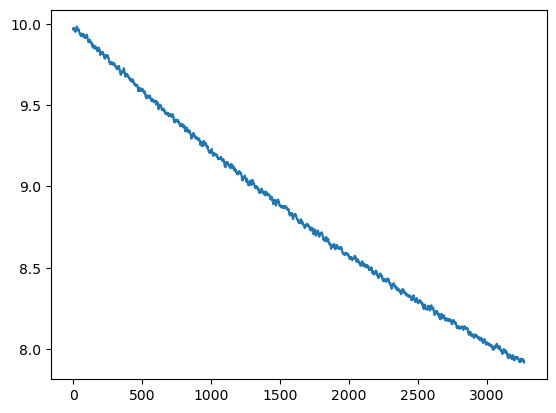

In [19]:
cumsum_vec = np.cumsum(np.insert(loss_history['total'], 0, 0)) 
window_width = 10
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)

In [33]:
embedding

tensor([[ 1.7961,  0.0542, -1.1558,  ..., -1.6025, -0.0305,  1.1156],
        [-0.0326,  0.0084,  0.0351,  ...,  0.2313, -0.0400,  0.1177],
        [ 0.0151,  0.1762, -0.1858,  ..., -0.3172,  0.1574,  0.2788],
        ...,
        [-1.7016,  0.6350,  1.0430,  ..., -0.2509,  0.5708, -0.4901],
        [ 1.3201,  0.8678,  1.2656,  ..., -0.5287,  0.2486,  0.8889],
        [ 0.4313, -1.9333, -0.6992,  ..., -0.1415,  0.3628,  0.3365]],
       requires_grad=True)

In [31]:
X_norm = (X-X.mean(axis=0)) / X.std(axis=0)

In [40]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

X = embedding.detach().numpy()
y = bc_dataset['labels']

clf = LogisticRegression(random_state=0, multi_class='ovr').fit(X_norm, y)
y_hat = clf.predict(X_norm)
f1_score(y, y_hat, average='micro')

0.13081846392552365

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)


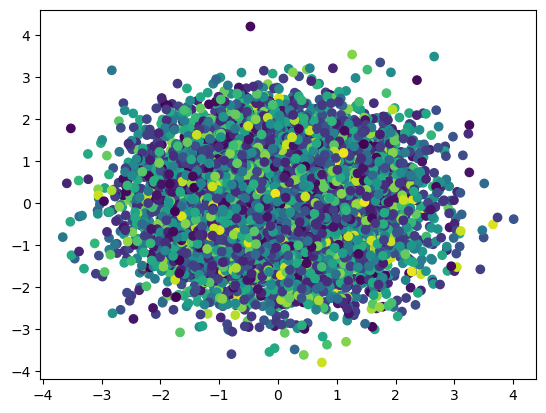

In [37]:
plt.scatter(X_t[:, 0], X_t[:, 1], c=y)